# Week 1: Dark Matter Freeze-Out 

Freeze-out: particles will stay in thermal equilibrium with the universe as long as the reactions keeping them in chemical equilibrium are proceeding at a rate higher than the expansion of the universe. If the expansion rate is faster than the reaction rate, the partices can no longer stay in equilibrium with the universe; they are 'frozen out'.


As the universe cools, $\Gamma \ll H$ and particles cannot find each other to annihilate. Particles begin to decouple at this point and their abundance becomes static at $T_{fo}$.


### Values and Units

We will work in natural units. Here are the values that we need:

$G_F=1.1663787 \times 10^{-5} \text{ GeV}^{-2}$

$M_{\text{Pl}}=2.435\times 10^{18}\text{ GeV}$

$k_B=1$

$T_0=0.235 \text{ meV}$

$\rho_{\text{crit}}=\frac{3H_0^2}{8\pi G}=1.0997\times10^{-8}\text{ eV}^4$

The ranges of $m_{\text{DM}}$ and of $\sigma_{\text{DM-DM}}$ that we need to plot over are:

$m_{\text{DM}}\in [0.1\text{ eV}, 10\text{ keV}] \text{ for hot dark matter}$

$m_{\text{DM}}\in [10\text{ MeV}, 10\text{ TeV}] \text{ for cold dark matter}$

$\sigma_{\text{DM-DM}}\in [G_F\times 10^{-6},G_F\times 10^6]$

## Part I: Plotting the Present Day Abundance for Hot and Cold Dark Matter

### Theoretical Background

We need to create plots of $\Omega_{\text{DM}}(m_{\text{DM}})$ and  $\Omega_{\text{DM}}(\sigma_{\text{DM-DM}})$

$$\Omega_{\text{DM}}=\frac{\rho_{\text{DM}}}{\rho_{\text{crit}}}$$

Here, $\rho_{\text{DM}}$ is the present value, which can be obtained as follows: 

We calculate $n_{\text{DM}}$ at decoupling, redshift it and then do $\rho_{\text{DM}}= n_{\text{DM},0}m_{\text{DM}}$, where $n_{\text{DM},0}$ can be obtained from the value at decoupling using $n_{\text{DM},0}=n_{\text{DM}}a^{-3}$

For cold dark matter (non-relativistic case):

$$n_{\text{DM}}=g\left(\frac{m_{\text{DM}}T}{2\pi}\right)^{3/2}e^{-m_{\text{DM}}/T}$$

For hot dark matter (relativistic case):

$$n_{\text{DM}}=\frac{\zeta(3)}{\pi^2}gT^3 \text{ for bosons, or }n_{\text{DM}}=\frac34\frac{\zeta(3)}{\pi^2}gT^3 \text{ for fermions.}$$

Let us first assume that the cross section for DM-DM interactions is
$$ \sigma_{\text{DM-DM}}=G_F^2T^2$$

The Hubble parameter, in the radiation dominated universe, is given by:
$$ H(T)=\frac{\pi}{3}\left(\frac{g_*}{10}\right)^{1/2}\frac{T^2}{M_{\text{Pl}}} $$

Using the equipartition theorem, we can compute the velocity of a gas of particles at a temperature $T$:
$$v=\sqrt{\frac{3k_BT}{m_{DM}}}$$


In [1]:
#dependencies. Include seaborn lines for prettier plots if the package is installed
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize
from scipy.optimize import fsolve
from scipy.misc import derivative
from scipy.integrate import odeint
from scipy.interpolate import interp1d
#import seaborn as sns
from scipy.integrate import solve_ivp
from IPython.display import Latex

#sns.set(rc={'text.usetex' : True})
#sns.set_context("paper", font_scale=2)
#sns.set_style("ticks", {'axes.grid': False,
#                        'axes.linewidth': 1.5,
#                        'legend.frameon':True,
#                        'useTex':True})

## $g_{*S}$ and $g_*$ extracted from [1]

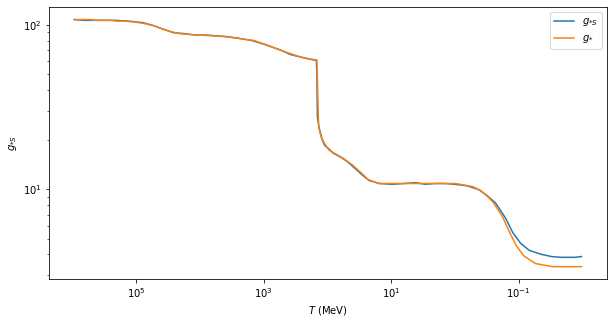

In [2]:
gstar_data = np.genfromtxt('gstar.csv', delimiter=',')

Ts_S=gstar_data[:,0]*10**6
Ts=gstar_data[:,2]*10**6
gstar_S=interp1d(Ts_S, gstar_data[:,1],kind='nearest',fill_value='extrapolate')
gstar=interp1d(Ts, gstar_data[:,3],kind='nearest',fill_value='extrapolate')

plt.figure(figsize=(10,5))
plt.plot(Ts_S*10**-6,gstar_S(Ts_S), label=r'$g_{*S}$')
plt.plot(Ts*10**-6,gstar(Ts), label=r'$g_{*}$')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$g_{*S}$')
plt.xlabel(r'$T$ (MeV)')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

### Steps:
1. Define functions for converting between a temperature T and a scale factor a.
2. Define functions and parameters for calculating the present-day abundance of DM. 
3. Plot $\Omega$(m) with constant $\sigma$ for both hot and cold DM. 
4. Plot $\Omega$($\sigma$) with constant m for both hot and cold DM. 

#### Converting between $a$ and $T$:

$$a^3g_{*S}(T)T^3=\text{const}$$

In [3]:
# STEP 1: define functions for converting between temperature T and scale factor a

T_0 = 0.235e-3
def T_to_a(T):
    return (gstar_S(T_0)/gstar_S(T))**(1/3)*(T_0/T)
def a_to_T(a):
    func = lambda T: a**3*(gstar_S(T))*T**3-gstar_S(T_0)*T_0**3
    T_initial_guess = gstar_S(T_0)**(1/3)*(T_0/a)
    T_solution = fsolve(func, T_initial_guess)
    return T_solution

In [4]:
# STEP 2: define parameters and functions for calculating present-day abundance of DM

# all parameters in natural units

G_F = 1.1663787*10**(-5)/((10**9)**2)
M_pl = 2.435*10**18*10**9
k_B = 1
c = 1
#assuming DM particles to be fermions
g = 2
crit_density = 8.07*10**(-47)*10**36

#rough approximations of H, n, and sigma. Replace freely
def H(T):
    return np.pi/3*(gstar(T)/10)**(1/2)*(T**2)/M_pl

#assuming DM particles to be fermions. rel = True -> hot DM
def n(T,rel=True,m=0):
    if rel:
        return 3/4*scipy.special.zeta(3)/(np.pi**2)*g*T**3
    else:
        if m == 0:
            raise Exception("for cold DM, mass needs to be specified")
        else:
            return g*(m*T/(2*np.pi))**(3/2)*np.exp(-m/T)

#average velocity of DM. Default = hot DM.
def v(T,rel=True,m=0):
    if rel == True:
        return c
    else:
        if m == 0:
            raise Exception("for cold DM, mass needs to be specified")
        else:
            return (3*k_B*T/m)**(1/2)

#cross-section of DM self-interaction. The parameter alpha can be varied for
#easy plotting of different values of sigma
def sigma(T,alpha=1):
    return alpha*(G_F**2)*(T**2)
    
#solve for freeze-out temperature T_fo
def T_fo_solver(rel=True,alpha=1,m=0):
    composite = lambda T: H(T) - (n(T,rel=rel,m=m)*v(T,rel=rel,m=m)*sigma(T,alpha))
    T_initial_guess = 10**12
    return fsolve(composite,T_initial_guess)

#present-day abundance of dark matter
def Omega(T,m,rel=True):
    return dm_density(T,m,rel)/crit_density

#dark matter density TODAY. n is the DM density at the decoupling, which needs
#to be multiplied by a scaling factor a^-3 accounting for expansion
def dm_density(T,m,rel=True):
    return m*n(T,rel,m)*T_to_a(T)**3

### Hot Dark Matter

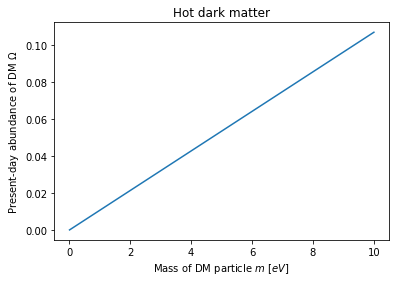

In [5]:
#plot Omega as a fn of m with constant sigma
m_vect = np.linspace(0.01,10,100)
Omega_vect = []
for m in m_vect:
    T_fo = T_fo_solver(rel=True,m=m)[0]
    Omega_vect.append(Omega(T_fo,m,True))
    
plt.plot(m_vect,Omega_vect)
plt.title("Hot dark matter")
plt.xlabel("Mass of DM particle $m$ [$eV$]")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

/home/anders/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


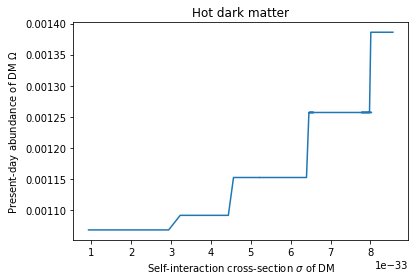

In [6]:
#plot Omega as a fn of sigma with constant m. parameter alpha
#defined for ease of plotting, see fn sigma
m_const = 0.1
alpha_vect = np.linspace(1,1000,100)
sigma_vect = []
Omega_vect = []
for alpha in alpha_vect:
    T_fo = T_fo_solver(rel=True,alpha=alpha,m=m_const)[0]
    sigma_vect.append(alpha*G_F**2*T_fo**2)
    Omega_vect.append(Omega(T_fo,m_const,True))
plt.plot(sigma_vect,Omega_vect)
plt.title("Hot dark matter")
plt.xscale('linear')
plt.xlabel("Self-interaction cross-section $\sigma$ of DM")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

### Cold Dark Matter

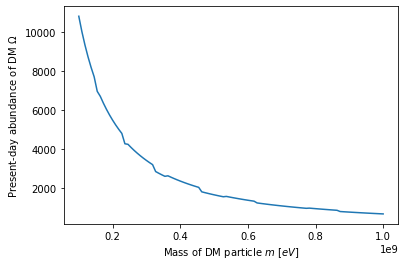

In [7]:
#plot Omega as a fn of m with constant sigma
m_vect = np.linspace(0.1*10**9,1*10**9,100)
Omega_vect = []
for m in m_vect:
    T_fo = T_fo_solver(rel=False,alpha=1,m=m)[0]
    Omega_vect.append(Omega(T_fo,m,False))
    
plt.plot(m_vect,Omega_vect)
plt.xlabel("Mass of DM particle $m$ [$eV$]")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

/home/anders/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


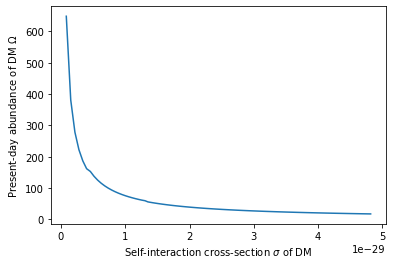

In [8]:
#plot Omega as a fn of sigma with constant m. parameter alpha
#defined for ease of plotting, see fn sigma
m_const = 10**9
alpha_vect = np.linspace(1,100,100)
sigma_vect = []
Omega_vect = []
for alpha in alpha_vect:
    T_fo = T_fo_solver(rel=False,alpha=alpha,m=m_const)[0]
    sigma_vect.append(alpha*G_F**2*T_fo**2)
    Omega_vect.append(Omega(T_fo,m_const,False))
plt.plot(sigma_vect,Omega_vect)
plt.xscale('linear')
plt.xlabel("Self-interaction cross-section $\sigma$ of DM")
plt.ylabel("Present-day abundance of DM $\Omega$")
plt.show()

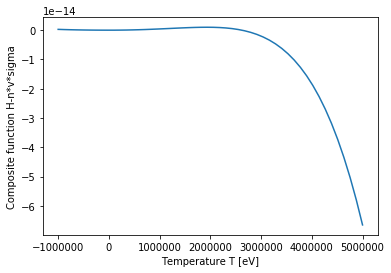

Freeze-out temperature T_fo = 2620352.6103422274 eV


In [9]:
#sanity check for T_fo_solver. Plot composite function for hot DM, make sure that the roots are valid

def T_fo_solver_copy(rel=True,alpha=1,m=0):
    composite = lambda T: H(T) - (n(T,rel=rel,m=m)*v(T,rel=rel,m=m)*sigma(T,alpha))
    T_vect = np.linspace(-10**6,5*10**6)
    composite_vect = []
    for i in T_vect:
        composite_vect.append(composite(i))
    plt.plot(T_vect,composite_vect)
    plt.xlabel("Temperature T [eV]")
    plt.ylabel("Composite function H-n*v*sigma")
    plt.show()
    T_initial_guess = 10**12
    return fsolve(composite,T_initial_guess)

print("Freeze-out temperature T_fo = {} eV".format(T_fo_solver_copy()[0]))

$T_{fo} = 2.6*10^6 \; eV \sim MeV$. Reasonable, as this is approximately the freeze-out temperature of neutrinos.  We're treating very light DM particles of relativistic speeds - basically neutrinos.

/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


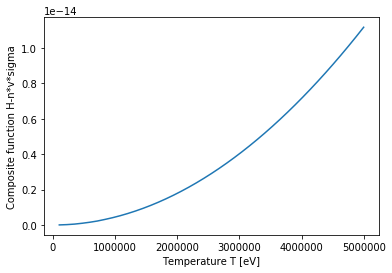

Freeze-out temperature T_fo = 78585735.83936624 eV
v = 0.48554835754855424


In [10]:
#sanity check for T_fo_solver. Plot composite function for cold DM, make sure that the roots are valid
#and that v falls between 0 and 1

#calculate T_fo for cold DM of mass 1 GeV
T_fo_test = T_fo_solver_copy(False,1,10**9)[0]
print("Freeze-out temperature T_fo = {} eV".format(T_fo_test))

#calculate v for cold DM of mass 1 GeV
print("v = {}".format(v(T_fo_test,False,10**9)))

In [17]:
#Calculate T_fo for cold DM with m = 0.01 GeV and sigma*v = 6.94379e-29 eV^-2
#for use in 
def T_fo_solver_fixed_sigma(sigma_v_fixed,rel=True,m=0):
    composite = lambda T: H(T) - (n(T,rel=rel,m=m)*v(T,rel=rel,m=m)*sigma_v_fixed/v(T,rel=rel,m=m))
    T_initial_guess = 10**12
    return fsolve(composite,T_initial_guess)

T_fo_solver_fixed_sigma(6.94379*10**-29,False,0.01*10**9)

array([739885.06906731])

## Part II:  Solver for the Cold Dark Matter Relic Abundance

### Theoretical Background

We consider a stable WIMP particle $\chi$ of mass m, produced during the early evolution of the Universe. $\chi$ has spin $1/2$ Majorana fermion so that $\chi$ is its own antiparticle and has $g_\chi$
 = 2 degrees of freedom. [2]

Evolution of the number of dark matter particles:

\begin{equation}
\frac{dn}{dt}+3Hn=\frac{d(na^3)}{a^3dt}=\langle\sigma v\rangle(n_{eq}^2-n^2)
\end{equation}

Replacing $n$ with $Y=n/s$, we can rewrite this equation as:

$$ \frac{dY}{dx}=\frac{s\langle\sigma v\rangle}{Hx}\left(1+\frac13\frac{d(\log g_s)}{d(\log T)}\right)(Y_{eq}^2-Y^2) $$

Here, $x=m/T$.

After calculating $Y$ at present we can plot the present day abundances using:

$$\Omega=\rho_{\text{DM}}/\rho_{\text{crit}}=m s_0 Y_0/\rho_{\text{crit}}$$

We can calculate $Y$ in multiple ways. The simplest (numerical) way is to solve the WIMP Evolution Equation which is given by:

\begin{equation}
\frac{dY}{dx} = \lambda \left [ 1 +\frac{1}{3} \frac{d(ln g_s)}{d(ln T)} \right ] \frac{g_s}   {{g_\rho}^{1/2}}    \frac{1}{x^2} ({Y_{eq}}^2 - {Y^2})
\end{equation}

This equation is of the form Y(x) where x = m/T. 

where 


$m\left \langle \sigma v \right \rangle$ is the thermally averaged annihilation rate factor. 

and 
\begin{equation}
\lambda \equiv 2.76\, \mathrm{x}\, 10^{35} m\left \langle \sigma v \right \rangle
\end{equation}

and 

\begin{equation}
Y_{eq} = 0.145 \, \frac{g_\chi }{g_s} x^\frac{3}{2} e^{-x}
\end{equation}


However, the above equation is computationally expensive and varies over a wide range of factors. So we can make the substitution W = lnY and get the following:

\begin{equation}
\frac{dW}{dx} = \frac{\lambda}{x^2} \left [ 1 +\frac{1}{3} \frac{d(ln g_s)}{d(ln T)} \right ] \frac{g_s} {{g_\rho}^{1/2}} (e^{(2W_{eq} - W)} - e^W)
\end{equation}

Our final equation that we want to solve for is:

\begin{equation}
\frac{dW}{dx} = \frac{2.76\, \mathrm{x}\, 10^{35} m\left \langle \sigma v \right \rangle}{x^2} \left [ 1 +\frac{1}{3} \frac{d(ln g)}{d(ln T)} \right ] g^\frac{1}{2}(e^{(2W_{eq} - W)} - e^W)
\end{equation}

#### Assumptions:

\begin{equation}
g = g_s = g_\rho
\end{equation}

\begin{equation}
10 MeV\, \preceq m \preceq 10 \,TeV
\end{equation}

\begin{equation}
1 MeV \leq T \leq 1 \,TeV
\end{equation}



In [12]:
# Define some useful constants:
g = 2
crit_dens = 6.53953e-11
T_0 = 0.000234822
h=0.7

def lamb(m,sigmav):
    """
    Returns lambda parameter from differential equation
    """
    return 2.76e35*m*(sigmav)

def Weq(x,m):
    """
    Returns Weq from differential equation
    """
    Yeq = (45/(2*np.pi**4))*(np.pi/8)**(1/2)*(g/gstar_S(m/x))*x**(3/2)*np.exp(-x)
    return np.log(Yeq)

def dloggdlogT(T):
    """
    Returns the derivative of log(g_{*S}) with respect to log(T)
    """
    func = lambda T: np.log(gstar_S(T))
    return derivative(func, np.log(T))

# function that returns dy/dt
def equation(x,W,m,sigmav):
    """
    Returns dW/dx as written in the differential equation
    """
    T = m/x
    frac = gstar_S(T)/(gstar(T)**(1/2))
    dWdx = (lamb(m,sigmav)/x**2)*(1+(1/3)*dloggdlogT(T))*frac*(np.exp(2*Weq(x,m)-W)-np.exp(W))
    return dWdx

def entr_dens(T):
    """
    Returns entropy density for a certain T
    """
    return (2*np.pi**2/45)*(gstar_S(T))*T**3

def solver(m=0.01, sigmav=3e-26, x=[10,1000]):
    """
    Solves the differential equation for a certain value of m and sigmav
    """
    if x[0]<1 or x[1]>1000:
        raise Exception("Trying to compute values outside of allowed range")
    xs = np.linspace(x[0],x[1],num=100)
    W0 = np.array([Weq(x[0],m)])
    function = lambda x,W: equation(x,W,m,sigmav)
    W = solve_ivp(function, [1,1000], y0=W0, t_eval=xs, method="BDF")
    Y = np.exp(W.y[0])
    Y0 = Y[-1]
    actual_mass = m*10**9
    omega = actual_mass*entr_dens(T_0)*Y0/crit_dens
    return Y, xs, omega*h**2

/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

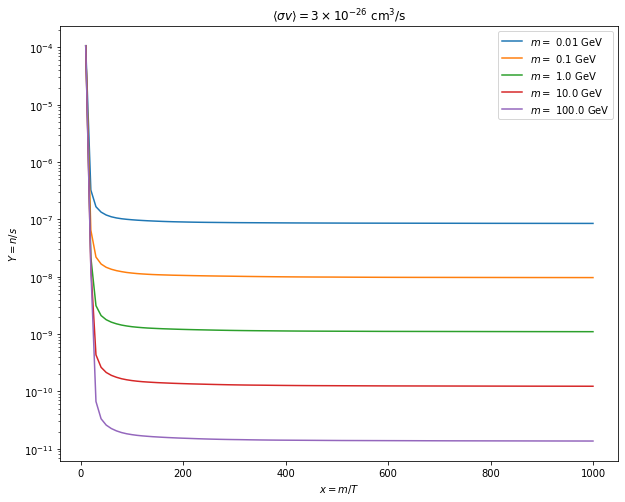

In [13]:
# Plotting Y(m)
ms = np.logspace(-2,2,num=5)
plt.figure(figsize=(10,8))
for m in ms:
    Y, xs, omegah2 = solver(m=m)
    plt.plot(xs, Y, label=r"$m =$ "+str(round(m,2))+" GeV")
    display(Latex(r"For $m = "+str(round(m,2))+"$ GeV, we get $\Omega h^2 = "+str(round(omegah2,3))+"$"))
plt.yscale('log')
plt.xscale('linear')
plt.ylabel(r'$Y=n/s$')
plt.xlabel(r'$x=m/T$')
plt.title(r"$\langle\sigma v\rangle = "+str(round(3,1))+"\\times 10^{-26} $ cm$^3/$s")
plt.legend()
plt.show()

/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

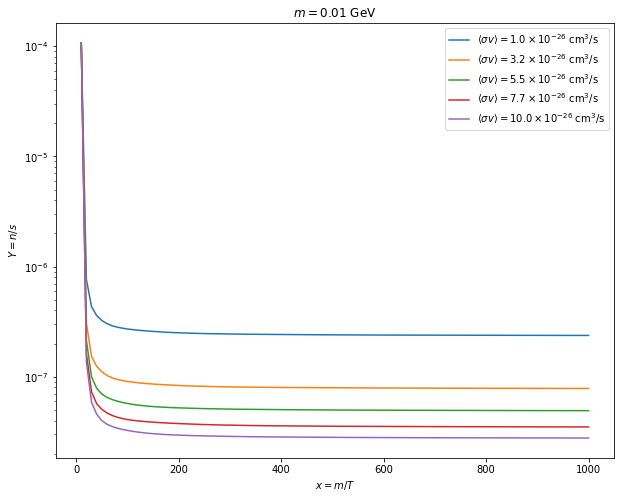

In [14]:
# Plotting Y(sigmav)
sigmavs = np.linspace(1e-26,1e-25,num=5)
plt.figure(figsize=(10,8))
for sigmav in sigmavs:
    Y, xs, omegah2 = solver(sigmav=sigmav)
    plt.plot(xs, Y, label=r"$\langle\sigma v\rangle = "+str(round(sigmav*10**26,1))+"\\times 10^{-26} $ cm$^3/$s")
    display(Latex(r"For $\langle\sigma v\rangle = "+str(round(sigmav*10**26,1))+"\\times 10^{-26} $ cm$^3/$s, we get $\Omega h^2 = "+str(round(omegah2,3))+"$"))
plt.yscale('log')
plt.xscale('linear')
plt.ylabel(r'$Y=n/s$')
plt.xlabel(r'$x=m/T$')
plt.title(r"$m="+str(0.01)+"$ GeV")
plt.legend()
plt.show()

/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Latex object>

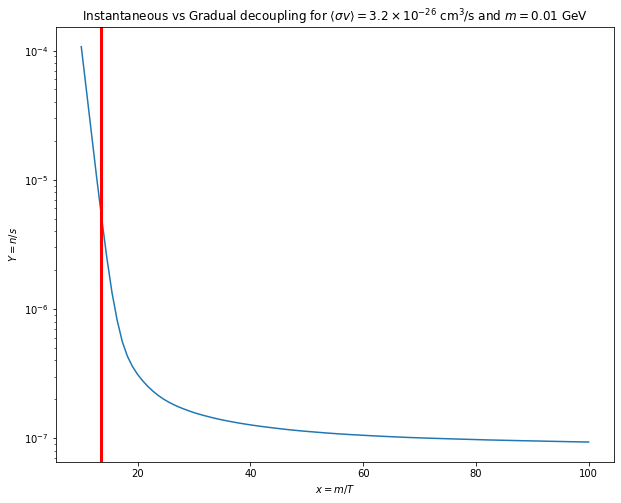

<IPython.core.display.Latex object>

In [15]:
# Comparing instantaneous decoupling to gradual decoupling:
T_fo = 0.739885e6
m = 0.01
sigmav = 3.2e-26
Y, xs, omegah2 = solver(sigmav=sigmav, m=m,x=[10,100])
plt.figure(figsize=(10,8))
plt.plot(xs, Y)
display(Latex(r"For $\langle\sigma v\rangle = "+str(round(sigmav*10**26,1))+"\\times 10^{-26} $ cm$^3/$s and $m = "+str(round(m,3))+"$ GeV we get $\Omega h^2 = "+str(round(omegah2,3))+"$"))
plt.yscale('log')
plt.xscale('linear')
plt.ylabel(r'$Y=n/s$')
plt.xlabel(r'$x=m/T$')
plt.axvline(x=m*10**9/T_fo, color="r",linewidth=3)
plt.title(r"Instantaneous vs Gradual decoupling for $\langle\sigma v\rangle = "+str(round(sigmav*10**26,1))+"\\times 10^{-26} $ cm$^3/$s and $m = "+str(round(m,3))+"$ GeV")
plt.show()
display(Latex(r"Red vertical line represents $x_{fo}=m/T_{fo}$ for instantaneous freeze-out. $T_{fo}="+str(round(T_fo*10**-6,2))+"$ MeV"))

### References:

[1] Cosmology Lecture Notes (Christoph Weniger, adopted from D. Baumann), Page 49


[2] Precise Relic WIMP Abundance and its Impact on Searches for Dark Matter Annihilation, Steigman et al. (2012)